In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
print(os.listdir("D:/Tensorflow/Brain/Attempt5_Inceptionv3/Trodat Dx"))

['test', 'train']


In [3]:
TRAIN_DIR = "D:/Tensorflow/Brain/Attempt5_Inceptionv3/Trodat Dx/train/"
TEST_DIR =  "D:/Tensorflow/Brain/Attempt5_Inceptionv3/Trodat Dx/test/"
print(os.listdir(TRAIN_DIR))

#影像長寬，這是inception_v3的輸入格式
imgSize = 299

In [6]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['normal']:
                label = 0
            elif nextDir in ['PD']:
                label = 1
            elif nextDir in ['PM']:
                label = 2
            else:
                label = 3
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (imgSize, imgSize, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [7]:
print("Loading train datas:")
X_train, y_train = get_data(TRAIN_DIR)
print("\nLoading test datas:")
X_test , y_test = get_data(TEST_DIR)

100%|████████████████████████████████████████████████████████████████████████████████| 318/318 [00:26<00:00, 12.16it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 12.37it/s]


In [9]:
print("images:")
print(X_train.shape,'\n',X_test.shape)
print("\nlabels:")
print(y_train.shape,'\n',y_test.shape)

(1409, 224, 224, 3) 
 (298, 224, 224, 3)


In [11]:
from keras.utils.np_utils import to_categorical

# https://keras.io/zh/utils/#to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

Using TensorFlow backend.


In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
#from keras import backend as K
#K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [13]:
X_train=X_train.reshape(X_train.shape[0], imgSize, imgSize, 3)
X_test=X_test.reshape(X_test.shape[0], imgSize, imgSize, 3)

In [14]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False , input_shape=(imgSize, imgSize, 3),classes=1000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [45]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
#x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(3 , activation='softmax')(x)

In [46]:
model = Model(inputs=base_model.input, outputs=predictions)

In [51]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [42]:
batch_size = 128
epochs = 20

In [19]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


In [59]:
#unfreezing some layers
unfreezeBelow = 249
for layer in model.layers[:unfreezeBelow]:
    layer.trainable = False
for layer in model.layers[unfreezeBelow:]:
    layer.trainable = True #True

#model.compile(loss='categorical_crossentropy', 
#                  optimizer='adam', 
#                  metrics=['accuracy'])

from keras import optimizers
opt = optimizers.Adam(lr=0.0001, decay=0.0005)
model.compile(loss='categorical_crossentropy', 
                  optimizer=opt, 
                  metrics=['accuracy'])

In [60]:
history = model.fit(X_train, y_train, batch_size=batch_size, shuffle=True, validation_data = (X_test , y_test) ,callbacks=[early_stop] ,
          epochs=epochs)

Train on 1409 samples, validate on 298 samples
Epoch 1/20
1409/1409 [==============================] - 8s 6ms/step - loss: 0.0146 - accuracy: 0.9943 - val_loss: 2.2092 - val_accuracy: 0.5336
Epoch 2/20
1409/1409 [==============================] - 4s 3ms/step - loss: 0.0131 - accuracy: 0.9965 - val_loss: 2.4290 - val_accuracy: 0.5235
Epoch 3/20
1409/1409 [==============================] - 4s 3ms/step - loss: 0.0140 - accuracy: 0.9929 - val_loss: 2.0586 - val_accuracy: 0.5738
Epoch 4/20
1409/1409 [==============================] - 4s 3ms/step - loss: 0.0105 - accuracy: 0.9943 - val_loss: 2.2369 - val_accuracy: 0.5570
Epoch 5/20
1409/1409 [==============================] - 4s 3ms/step - loss: 0.0117 - accuracy: 0.9950 - val_loss: 2.4288 - val_accuracy: 0.5537


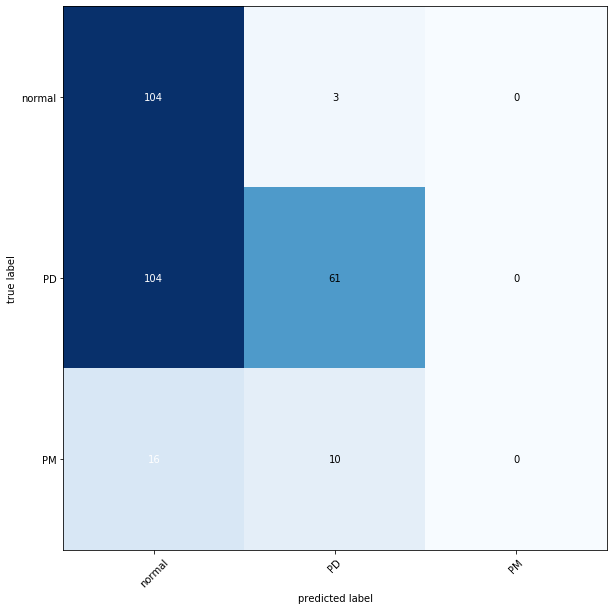

In [61]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

CATEGORIES = ["normal", "PD", "PM"]
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM , figsize=(10,10), class_names=CATEGORIES, cmap=plt.cm.Blues)
plt.show()

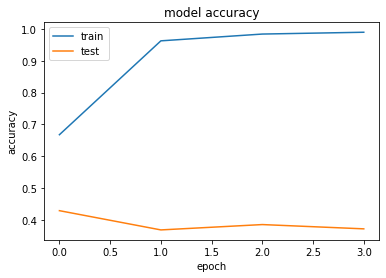

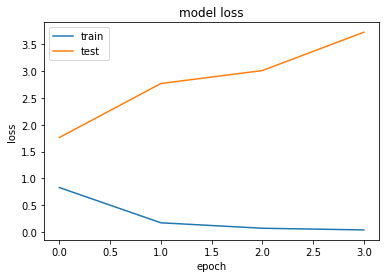

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
#model.save('modelForJs.h5')
#model.save('model.model')